<a href="https://colab.research.google.com/github/fjadidi2001/Image_Inpaint/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install tensorflow pillow numpy matplotlib scikit-image opencv-python

In [10]:
from google.colab import files
uploaded = files.upload()  # This will prompt you to upload your image

Saving Mona_Lisa.jpg to Mona_Lisa.jpg


Generator Summary:


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)                   │ (None, 128, 128, 64)        │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_48 (LeakyReLU)           │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 64, 64, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_49 (LeakyReLU)           │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_38 (Conv2D)                   │ (None, 32, 32, 256)         │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_50 (LeakyReLU)           │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_18                  │ (None, 64, 64, 128)         │         524,416 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_51 (LeakyReLU)           │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_19                  │ (None, 128, 128, 64)        │         131,136 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_52 (LeakyReLU)           │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_20                  │ (None, 256, 256, 3)         │           3,075 │
│ (Conv2DTranspose)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,317,507 (5.03 MB)

 Trainable params: 1,317,507 (5.03 MB)

 Non-trainable params: 0 (0.00 B)


Discriminator Summary:


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_39 (Conv2D)                   │ (None, 128, 128, 64)        │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_53 (LeakyReLU)           │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_40 (Conv2D)                   │ (None, 64, 64, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_54 (LeakyReLU)           │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 32, 32, 256)         │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_55 (LeakyReLU)           │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 262144)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │         262,145 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 921,025 (3.51 MB)

 Trainable params: 921,025 (3.51 MB)

 Non-trainable params: 0 (0.00 B)

Starting training with 1 images for 100 epochs
Epoch 0, Batch 0: Gen Loss = 0.1340, Disc Loss = 1.3772
Epoch 1, Batch 0: Gen Loss = 0.0623, Disc Loss = 1.3903
Epoch 2, Batch 0: Gen Loss = 0.1247, Disc Loss = 1.2509
Epoch 3, Batch 0: Gen Loss = 0.0338, Disc Loss = 1.4691
Epoch 4, Batch 0: Gen Loss = 0.0200, Disc Loss = 1.3192
Epoch 5, Batch 0: Gen Loss = 0.0939, Disc Loss = 1.3041
Epoch 6, Batch 0: Gen Loss = 0.0016, Disc Loss = 1.3835
Epoch 7, Batch 0: Gen Loss = 0.0847, Disc Loss = 1.2383
Epoch 8, Batch 0: Gen Loss = 0.0871, Disc Loss = 1.2930
Epoch 9, Batch 0: Gen Loss = 0.1597, Disc Loss = 1.1104
Epoch 10, Batch 0: Gen Loss = 0.0195, Disc Loss = 1.3300
Epoch 11, Batch 0: Gen Loss = 0.0712, Disc Loss = 1.1034
Epoch 12, Batch 0: Gen Loss = 0.0689, Disc Loss = 1.1736
Epoch 13, Batch 0: Gen Loss = 0.0222, Disc Loss = 1.4210
Epoch 14, Batch 0: Gen Loss = 0.0708, Disc Loss = 0.8817
Epoch 15, Batch 0: Gen Loss = 0.1862, Disc Loss = 0.7377
Epoch 16, Batch 0: Gen Loss = 0.0979, Disc Loss = 0

PSNR: 15.70
SSIM: 0.92


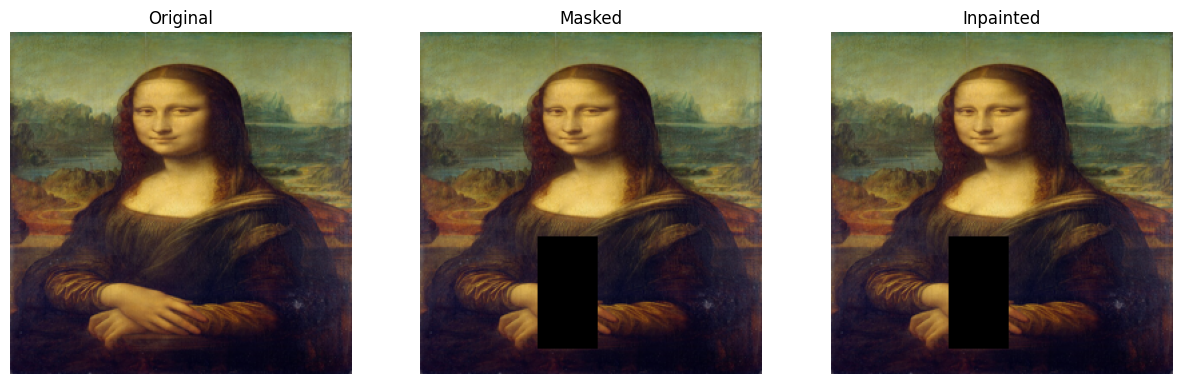

In [16]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from PIL import Image
import cv2

# Step 1: Load and prepare data
def load_image(image_path, size=(256, 256)):
    """Load and resize image"""
    img = Image.open(image_path)
    img = img.resize(size)
    img = np.array(img) / 255.0  # Normalize to [0,1]
    return img

def load_dataset(directory, size=(256, 256)):
    """Load all images from directory"""
    images = []
    for filename in os.listdir(directory):
        if filename.endswith((".png", ".jpg", ".jpeg")):
            img_path = os.path.join(directory, filename)
            img = load_image(img_path, size)
            images.append(img)
    return np.array(images)

# Step 2: Preprocess images
def preprocess_images(images):
    """Preprocess images for the model"""
    # Convert to float32
    images = images.astype('float32')
    # Ensure values are in [-1, 1]
    images = (images * 2) - 1
    return images

# Step 3: Create mask
def create_random_mask(shape, max_boxes=5):
    """Create random rectangular masks"""
    mask = np.ones(shape, dtype=np.float32)  # Specify dtype as float32
    for _ in range(np.random.randint(1, max_boxes)):
        x1, x2 = sorted(np.random.randint(0, shape[1], 2))
        y1, y2 = sorted(np.random.randint(0, shape[0], 2))
        mask[y1:y2, x1:x2] = 0
    return mask

# Step 4: Define Generator and Discriminator
def build_generator():
    """Create the generator model"""
    model = tf.keras.Sequential([
        # Encoder
        layers.Input(shape=(256, 256, 3)),
        layers.Conv2D(64, 4, strides=2, padding='same'),
        layers.LeakyReLU(0.2),
        layers.Conv2D(128, 4, strides=2, padding='same'),
        layers.LeakyReLU(0.2),
        layers.Conv2D(256, 4, strides=2, padding='same'),
        layers.LeakyReLU(0.2),

        # Decoder
        layers.Conv2DTranspose(128, 4, strides=2, padding='same'),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(64, 4, strides=2, padding='same'),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(3, 4, strides=2, padding='same', activation='tanh')
    ])
    return model

def build_discriminator():
    """Create the discriminator model"""
    model = tf.keras.Sequential([
        layers.Input(shape=(256, 256, 3)),
        layers.Conv2D(64, 4, strides=2, padding='same'),
        layers.LeakyReLU(0.2),
        layers.Conv2D(128, 4, strides=2, padding='same'),
        layers.LeakyReLU(0.2),
        layers.Conv2D(256, 4, strides=2, padding='same'),
        layers.LeakyReLU(0.2),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# Step 5: Combine into DCGAN
class DCGAN(tf.keras.Model):
    def __init__(self):
        super(DCGAN, self).__init__()
        self.generator = build_generator()
        self.discriminator = build_discriminator()

        # Optimizers
        self.gen_optimizer = tf.keras.optimizers.Adam(1e-4)
        self.disc_optimizer = tf.keras.optimizers.Adam(1e-4)

        # Loss
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy()
        self.mse = tf.keras.losses.MeanSquaredError()

    @tf.function
    def train_step(self, images, masks):
        """Single training step"""
        batch_size = tf.shape(images)[0]

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            # Generate images
            masked_images = images * masks
            generated_images = self.generator(masked_images, training=True)

            # Combine real and generated images
            filled_images = masked_images + (1 - masks) * generated_images

            # Train discriminator
            real_output = self.discriminator(images, training=True)
            fake_output = self.discriminator(filled_images, training=True)

            # Calculate losses
            gen_loss = self.mse(images, filled_images)
            disc_loss = self.cross_entropy(tf.ones_like(real_output), real_output) + \
                       self.cross_entropy(tf.zeros_like(fake_output), fake_output)

        # Apply gradients
        gen_gradients = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        disc_gradients = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.gen_optimizer.apply_gradients(zip(gen_gradients, self.generator.trainable_variables))
        self.disc_optimizer.apply_gradients(zip(disc_gradients, self.discriminator.trainable_variables))

        return gen_loss, disc_loss

# Step 6: Training function
def train_model(model, dataset, epochs=100, batch_size=1):
    """Train the model"""
    print(f"Starting training with {len(dataset)} images for {epochs} epochs")

    for epoch in range(epochs):
        for batch in range(0, len(dataset), batch_size):
            # Get batch of images
            batch_images = dataset[batch:batch + batch_size]

            # Create masks for this batch
            masks = np.stack([create_random_mask((256, 256)) for _ in range(len(batch_images))])
            masks = np.expand_dims(masks, axis=-1)
            masks = np.repeat(masks, 3, axis=-1)

            # Convert masks to float32
            masks = tf.cast(masks, tf.float32)
            # Ensure images are float32
            batch_images = tf.cast(batch_images, tf.float32)

            # Train on batch
            try:
                gen_loss, disc_loss = model.train_step(batch_images, masks)
                if batch % 10 == 0:
                    print(f"Epoch {epoch}, Batch {batch}: Gen Loss = {gen_loss:.4f}, Disc Loss = {disc_loss:.4f}")
            except Exception as e:
                print(f"Error in batch {batch}: {str(e)}")
                raise e
# Step 7: Evaluation functions
def evaluate_model(model, test_image, test_mask):
    """Evaluate model on a single test image"""
    # Ensure correct types
    test_image = tf.cast(test_image, tf.float32)
    test_mask = tf.cast(test_mask, tf.float32)

    # Generate inpainted image
    masked_image = test_image * test_mask
    generated = model.generator(np.expand_dims(masked_image, 0), training=False)
    generated = generated[0].numpy()

    # Combine masked and generated portions
    inpainted = masked_image.numpy() + (1 - test_mask.numpy()) * generated

    # Calculate metrics
    psnr_value = psnr(test_image.numpy(), inpainted)
    # Modify SSIM calculation with smaller window size
    ssim_value = ssim(test_image.numpy(), inpainted,
                      win_size=5,  # Smaller window size
                      channel_axis=2,  # Specify channel axis for RGB images
                      data_range=1.0)  # Specify data range [0,1]

    return inpainted, psnr_value, ssim_value

# Step 8: Visualization function
def visualize_results(original, masked, inpainted):
    """Visualize original, masked, and inpainted images"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(original)
    axes[0].set_title('Original')
    axes[0].axis('off')

    axes[1].imshow(masked)
    axes[1].set_title('Masked')
    axes[1].axis('off')

    axes[2].imshow(inpainted)
    axes[2].set_title('Inpainted')
    axes[2].axis('off')

    plt.show()

def main():
    # Load dataset
    image_path = "Mona_Lisa.jpg"

    # Ensure the file exists
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Could not find image at {image_path}")

    # Load and prepare single image
    image = load_image(image_path)
    images = np.expand_dims(image, axis=0)
    images = preprocess_images(images)
    # Ensure float32
    images = tf.cast(images, tf.float32)

    # Create and train model
    model = DCGAN()

    print("Generator Summary:")
    model.generator.summary()
    print("\nDiscriminator Summary:")
    model.discriminator.summary()

    try:
        train_model(model, images, epochs=100, batch_size=1)
    except Exception as e:
        print(f"Training error: {str(e)}")
        return

    try:
        test_image = load_image(image_path)
        test_mask = create_random_mask((256, 256))
        test_mask = np.expand_dims(test_mask, axis=-1)
        test_mask = np.repeat(test_mask, 3, axis=-1)

        # Get results
        inpainted, psnr_value, ssim_value = evaluate_model(model, test_image, test_mask)

        # Print metrics
        print(f"PSNR: {psnr_value:.2f}")
        print(f"SSIM: {ssim_value:.2f}")

        # Visualize results
        masked_image = test_image * test_mask
        visualize_results(test_image, masked_image, inpainted)

    except Exception as e:
        print(f"Evaluation error: {str(e)}")

if __name__ == "__main__":
    main()